In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly as py
import datetime
import glob
import seaborn as sns
import haversine as hs
import folium
import mpl_toolkits
import networkx as nx
import nxviz as nv
import janitor
import warnings
import plotly.express as px

from fiona.crs import from_epsg
from geopy import distance
from geopy.distance import geodesic
from sklearn.cluster import KMeans
from shapely.geometry import Point
from math import cos, asin, sin, atan2, sqrt, radians
from mpl_toolkits.basemap import Basemap
from networkx.drawing.nx_agraph import graphviz_layout
from nxviz import ArcPlot
from nxviz import annotate
from nxviz import CircosPlot
#from nxviz import GeoPlot
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from statsmodels.distributions.empirical_distribution import ECDF
from itertools import combinations

warnings.filterwarnings('ignore')

C:\Users\sowre\Anaconda3\lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.2 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.2, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [3]:
########## Reading only the voyages in service 2 ##########
service2_df = pd.read_csv("Service_2.csv", header = 0)
service2_df = service2_df.query('schedule in ["1","2","3","4","5","6"]')

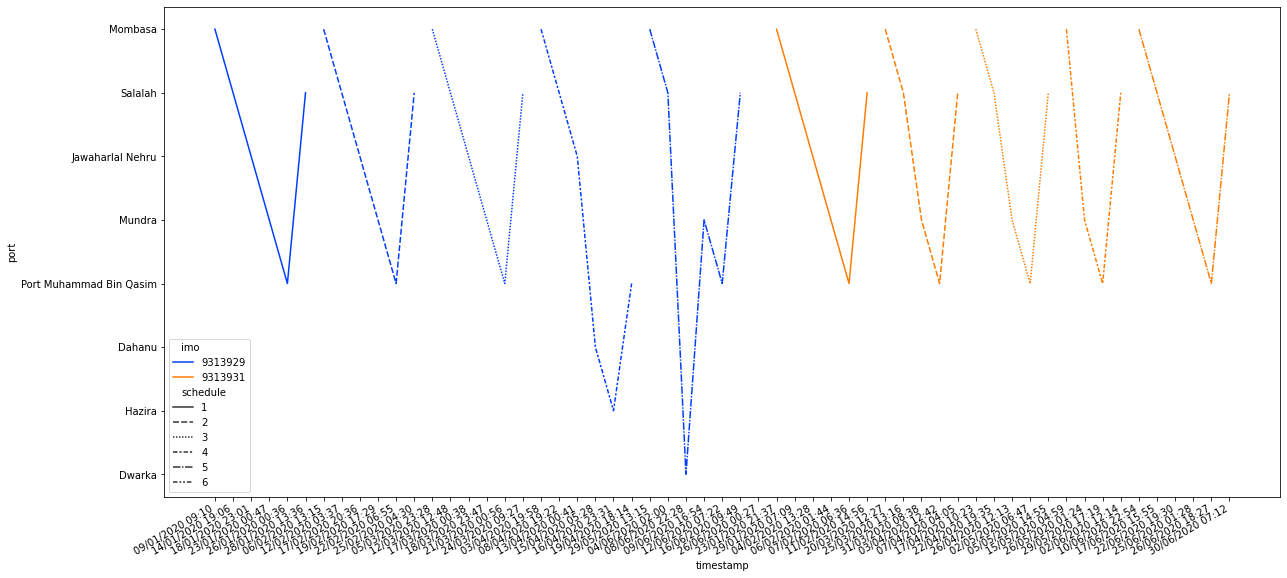

In [4]:
########## Ship's Service Pattern ##########
fig,ax = plt.subplots(figsize=(20,10))
service2_ports = service2_df[pd.notnull(service2_df['port'])]

#x_dates = service2_ports['timestamp'].dt.strftime('%Y-%m-%d').sort_values().unique()
sns.lineplot(x='timestamp', y='port', hue='imo', style='schedule', palette='bright', data=service2_ports)
fig.autofmt_xdate()
#sns.despine(fig)
#service2_ports.to_csv('service2_ports.csv')

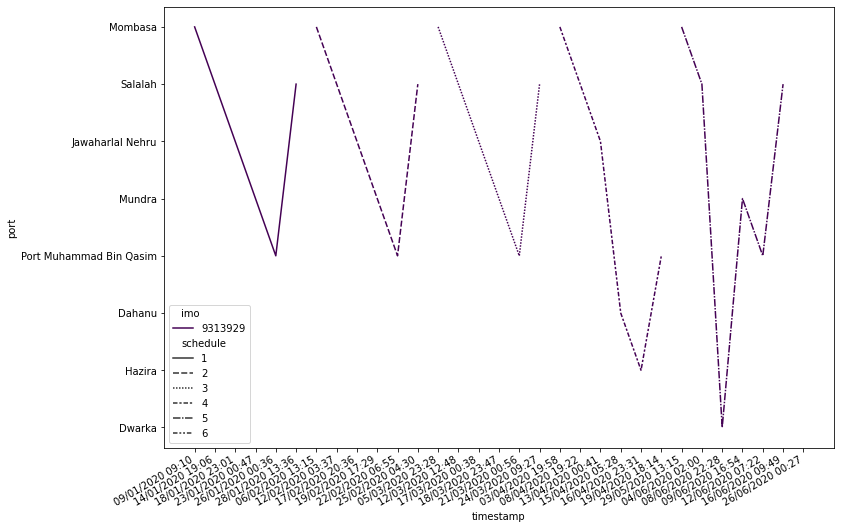

In [5]:
service2_df_imo = service2_df.query('imo==9313929')
fig,ax = plt.subplots(figsize=(12,9))
service2_df_imo = service2_df_imo[pd.notnull(service2_df['port'])]

sns.lineplot(x='timestamp', y='port', hue='imo', style='schedule', palette='viridis', data=service2_df_imo)
fig.autofmt_xdate()

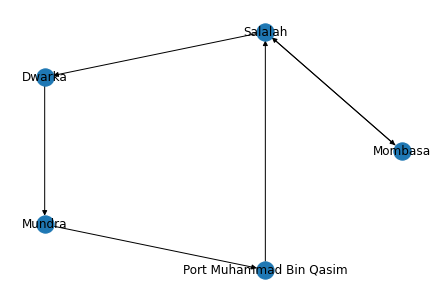

In [15]:
########## Network graph of a specific voyage in Service 2 ##########
#service2_ports_by_imo = service2_ports.query('imo==9313931')
service2_ports_by_imo = service2_ports.query('imo==9313929 and schedule=="5"')

trips = (
    service2_ports_by_imo
    .groupby(["port", "port_to"])
    .count()
    .reset_index()
    .select_columns(
        [
            "port", 
            "port_to", 
            "tripid"
        ]
    )
    .rename_column("tripid", "num_trips")
)

schedule_9313929 = nx.MultiDiGraph()

schedule_9313929 = nx.from_pandas_edgelist(service2_ports_by_imo, source='port', target='port_to',
                                          edge_attr=["schedule"],
                                          create_using=nx.MultiDiGraph())
#nx.draw(schedule, with_labels=True, font_weight='bold')
nx.draw_circular(schedule_9313929, with_labels=True)

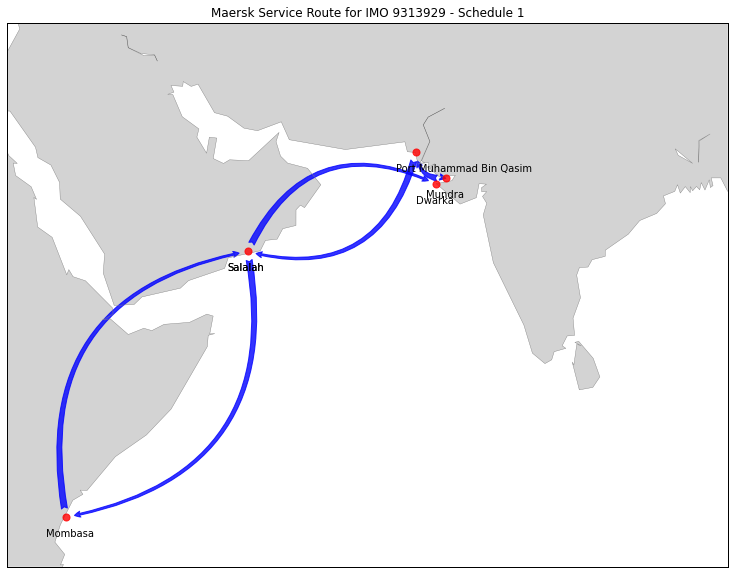

In [37]:
########## Plotting the Network in Geospace map ##########
fig,ax=plt.subplots(figsize=(20,10))
minlon = -5
minlat = -20
maxlon = 78
maxlat = 55
lat0 = (maxlat+minlat)/2
lon0 = (maxlon+minlon)/2
lat1 = (maxlat+minlat)/2-20
#m = Basemap(llcrnrlon=minlon,llcrnrlat=minlat,urcrnrlon=maxlon,urcrnrlat=maxlat,rsphere=(6378137.00,6356752.3142),resolution='l',projection='merc',lat_0=lat0,lon_0=lon0,lat_ts = lat1)
m=Basemap(llcrnrlon=35, llcrnrlat=-8,urcrnrlon=92,urcrnrlat=35)
mx, my = m(service2_ports_by_imo['lng'].values, service2_ports_by_imo['lat'].values)
m.drawmapboundary(fill_color='white')
m.drawcoastlines(color='grey', linewidth=0.4)
m.fillcontinents(color='lightgrey',lake_color='white')
plt.title('Maersk Service Route for IMO 9313929 - Schedule 1')
labels = service2_ports_by_imo.port.values
for label, xpt, ypt in zip(labels, service2_ports_by_imo.lng.values, service2_ports_by_imo.lat.values):
    plt.annotate(label, xy=m(xpt, ypt), xycoords="data", xytext=(-20,-20), textcoords='offset pixels')    
pos = {}
for count, elem in enumerate (service2_ports_by_imo['port']):
     pos[elem] = (mx[count], my[count])
pos

nx.draw_networkx_nodes(G = schedule_9313929, pos = pos, nodelist=list(schedule_9313929),
                        node_color = 'r', alpha = 0.8, node_size = 50)
nx.draw_networkx_edges(G = schedule_9313929, pos = pos, edge_color='b',
                        alpha=0.8, arrows = True, connectionstyle = 'arc3,rad=-0.5', arrowstyle='fancy', arrowsize=15)

#m.bluemarble()
#plt.tight_layout()
plt.show()

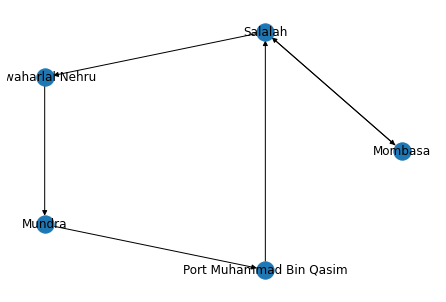

In [172]:
########## Network graph of a specific voyage in Service 2 ##########
service2_ports_by_imo = service2_ports.query('imo==9313929 and schedule=="1"')

trips = (
    service2_ports_by_imo
    .groupby(["port", "port_to"])
    .count()
    .reset_index()
    .select_columns(
        [
            "port", 
            "port_to", 
            "tripid"
        ]
    )
    .rename_column("tripid", "num_trips")
)

schedule_9313929 = nx.MultiDiGraph()

schedule_9313929 = nx.from_pandas_edgelist(service2_ports_by_imo, source='port', target='port_to',
                                          edge_attr=["schedule"],
                                          create_using=nx.MultiDiGraph())
#nx.draw(schedule, with_labels=True, font_weight='bold')
nx.draw_circular(schedule_9313929, with_labels=True)

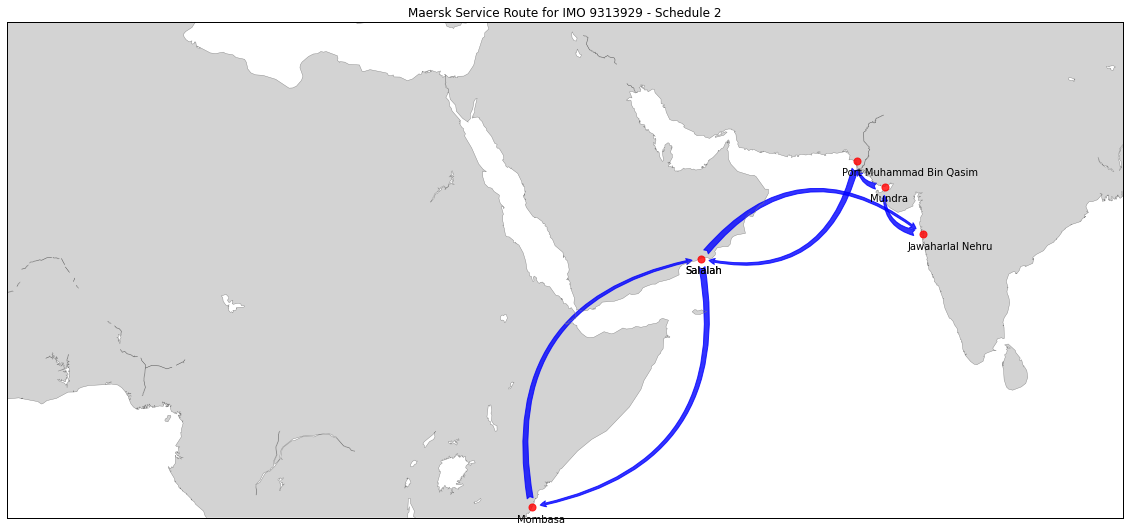

In [173]:
########## Plotting the Network in Geospace map ##########
fig,ax=plt.subplots(figsize=(20,10))
minlon = -5
minlat = -5
maxlon = 90
maxlat = 35
lat0 = (maxlat+minlat)/2
lon0 = (maxlon+minlon)/2
lat1 = (maxlat+minlat)/2-20
m = Basemap(llcrnrlon=minlon,llcrnrlat=minlat,urcrnrlon=maxlon,urcrnrlat=maxlat,rsphere=(6378137.00,6356752.3142),resolution='l',projection='merc',lat_0=lat0,lon_0=lon0,lat_ts = lat1)
#m=Basemap(llcrnrlon=-180, llcrnrlat=-70,urcrnrlon=180,urcrnrlat=70)
mx, my = m(service2_ports_by_imo['lng'].values, service2_ports_by_imo['lat'].values)
m.drawmapboundary(fill_color='white')
m.drawcoastlines(color='grey', linewidth=0.4)
m.fillcontinents(color='lightgrey',lake_color='white')
plt.title('Maersk Service Route for IMO 9313929 - Schedule 2')
labels = service2_ports_by_imo.port.values
for label, xpt, ypt in zip(labels, service2_ports_by_imo.lng.values, service2_ports_by_imo.lat.values):
    plt.annotate(label, xy=m(xpt, ypt), xycoords="data", xytext=(-15,-15), textcoords='offset pixels')
    
pos = {}
for count, elem in enumerate (service2_ports_by_imo['port']):
     pos[elem] = (mx[count], my[count])
pos

nx.draw_networkx_nodes(G = schedule_9313929, pos = pos, nodelist=list(schedule_9313929),
                        node_color = 'r', alpha = 0.8, node_size = 50)
nx.draw_networkx_edges(G = schedule_9313929, pos = pos, edge_color='b',
                        alpha=0.8, arrows = True, connectionstyle = 'arc3,rad=-0.5', arrowstyle='fancy', arrowsize=15)

#m.bluemarble()
#plt.tight_layout()
plt.show()

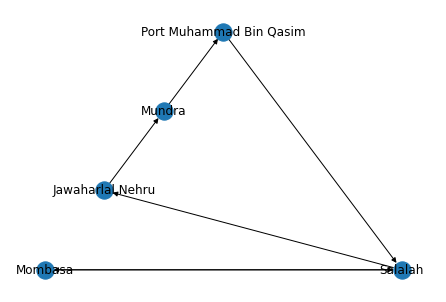

In [40]:
########## Network graph of a specific voyage in Service 2 ##########
service2_ports_by_imo = service2_ports.query('imo==9313931 and schedule=="1"')

trips = (
    service2_ports_by_imo
    .groupby(["port", "port_to"])
    .count()
    .reset_index()
    .select_columns(
        [
            "port", 
            "port_to", 
            "tripid"
        ]
    )
    .rename_column("tripid", "num_trips")
)

schedule_9313931 = nx.MultiDiGraph()

schedule_9313931 = nx.from_pandas_edgelist(service2_ports_by_imo, source='port', target='port_to',
                                          edge_attr=["schedule"],
                                          create_using=nx.MultiDiGraph())
#nx.draw(schedule, with_labels=True, font_weight='bold')
#nx.draw_circular(schedule_9313931, with_labels=True)
nx.draw_planar(schedule_9313931, with_labels=True)

In [43]:
# List Nodes in the Schedule
nodes = schedule_9313931.nodes()
list(nodes)

['Mombasa', 'Salalah', 'Jawaharlal Nehru', 'Mundra', 'Port Muhammad Bin Qasim']

In [44]:
# List Edges in the Schedule
edges = list(schedule_9313931.edges())
edges

[('Mombasa', 'Salalah'),
 ('Salalah', 'Jawaharlal Nehru'),
 ('Salalah', 'Mombasa'),
 ('Jawaharlal Nehru', 'Mundra'),
 ('Mundra', 'Port Muhammad Bin Qasim'),
 ('Port Muhammad Bin Qasim', 'Salalah')]

In [47]:
# List Degree Centrality of each Node in the Schedule
deg_centrality = list(nx.degree_centrality(schedule_9313931).items())
deg_centrality

[('Mombasa', 0.5),
 ('Salalah', 1.0),
 ('Jawaharlal Nehru', 0.5),
 ('Mundra', 0.5),
 ('Port Muhammad Bin Qasim', 0.5)]

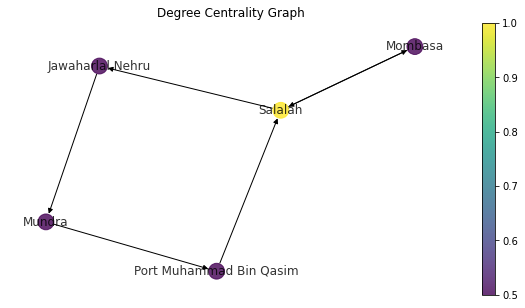

In [78]:
########## Network graph of a specific voyage in Service 2 ##########
fig, ax1 = plt.subplots(figsize=(10, 5))
deg = nx.degree_centrality(schedule_9313931)
pos = nx.kamada_kawai_layout(schedule_9313931)
nx.draw_networkx_labels(schedule_9313931, pos, alpha = 0.8)
nodes = nx.draw_networkx_nodes(schedule_9313931, pos, nodelist=deg.keys(),
                        node_color = list(deg.values()), alpha = 0.8, node_size = 250)
edges = nx.draw_networkx_edges(schedule_9313931, pos)

plt.title('Degree Centrality Graph')
plt.colorbar(nodes)
plt.axis('off')
plt.show()

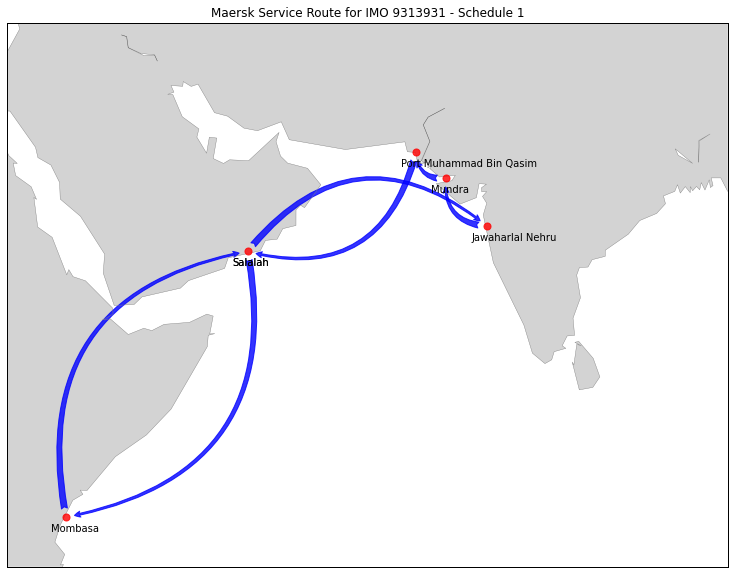

In [42]:
########## Plotting the Network in Geospace map ##########
fig,ax=plt.subplots(figsize=(20,10))
minlon = -5
minlat = -5
maxlon = 80
maxlat = 35
lat0 = (maxlat+minlat)/2
lon0 = (maxlon+minlon)/2
lat1 = (maxlat+minlat)/2-20
#m = Basemap(llcrnrlon=minlon,llcrnrlat=minlat,urcrnrlon=maxlon,urcrnrlat=maxlat,rsphere=(6378137.00,6356752.3142),resolution='l',projection='merc',lat_0=lat0,lon_0=lon0,lat_ts = lat1)
m=Basemap(llcrnrlon=35, llcrnrlat=-8,urcrnrlon=92,urcrnrlat=35)
mx, my = m(service2_ports_by_imo['lng'].values, service2_ports_by_imo['lat'].values)
m.drawmapboundary(fill_color='white')
m.drawcoastlines(color='grey', linewidth=0.4)
m.fillcontinents(color='lightgrey',lake_color='white')
plt.title('Maersk Service Route for IMO 9313931 - Schedule 1')
labels = service2_ports_by_imo.port.values
for label, xpt, ypt in zip(labels, service2_ports_by_imo.lng.values, service2_ports_by_imo.lat.values):
    plt.annotate(label, xy=m(xpt, ypt), xycoords="data", xytext=(-15,-15), textcoords='offset pixels')
    
pos = {}
for count, elem in enumerate (service2_ports_by_imo['port']):
     pos[elem] = (mx[count], my[count])
pos

nx.draw_networkx_nodes(G = schedule_9313931, pos = pos, nodelist=list(schedule_9313931),
                        node_color = 'r', alpha = 0.8, node_size = 50)
nx.draw_networkx_edges(G = schedule_9313931, pos = pos, edge_color='b',
                        alpha=0.8, arrows = True, connectionstyle = 'arc3,rad=-0.5', arrowstyle='fancy', arrowsize=15)

#m.bluemarble()
#plt.tight_layout()
plt.show()

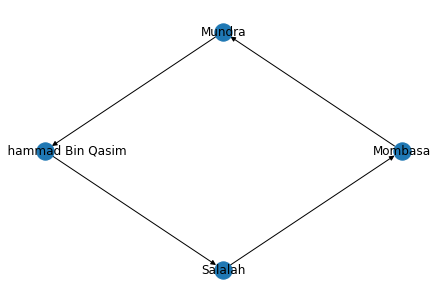

In [176]:
########## Network graph of a specific voyage in Service 2 ##########
service2_ports_by_imo = service2_ports.query('imo==9313931 and schedule=="4"')

trips = (
    service2_ports_by_imo
    .groupby(["port", "port_to"])
    .count()
    .reset_index()
    .select_columns(
        [
            "port", 
            "port_to", 
            "tripid"
        ]
    )
    .rename_column("tripid", "num_trips")
)

schedule_9313931 = nx.MultiDiGraph()

schedule_9313931 = nx.from_pandas_edgelist(service2_ports_by_imo, source='port', target='port_to',
                                          edge_attr=["schedule"],
                                          create_using=nx.MultiDiGraph())
#nx.draw(schedule, with_labels=True, font_weight='bold')
nx.draw_circular(schedule_9313931, with_labels=True)

NameError: name 'schedule_9313931' is not defined

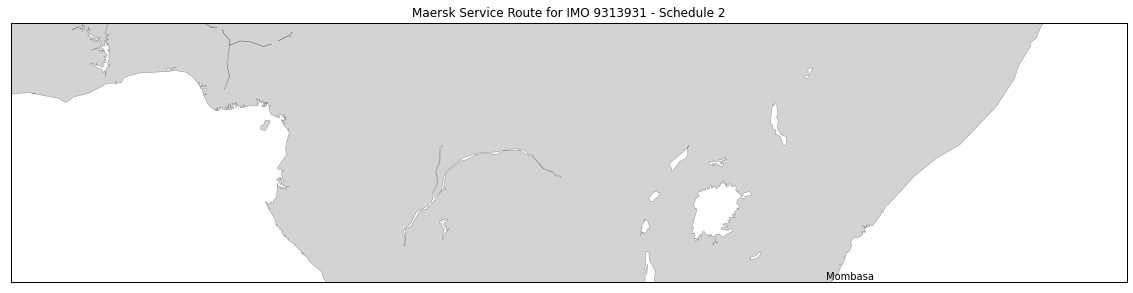

In [7]:
########## Plotting the Network in Geospace map ##########
fig,ax=plt.subplots(figsize=(20,10))
minlon = -5
minlat = -5
maxlon = 55
maxlat = 9
lat0 = (maxlat+minlat)/2
lon0 = (maxlon+minlon)/2
lat1 = (maxlat+minlat)/2-20
m = Basemap(llcrnrlon=minlon,llcrnrlat=minlat,urcrnrlon=maxlon,urcrnrlat=maxlat,rsphere=(6378137.00,6356752.3142),resolution='l',projection='merc',lat_0=lat0,lon_0=lon0,lat_ts = lat1)
#m=Basemap(llcrnrlon=-180, llcrnrlat=-70,urcrnrlon=180,urcrnrlat=70)
mx, my = m(service2_ports_by_imo['lng'].values, service2_ports_by_imo['lat'].values)
m.drawmapboundary(fill_color='white')
m.drawcoastlines(color='grey', linewidth=0.4)
m.fillcontinents(color='lightgrey',lake_color='white')
plt.title('Maersk Service Route for IMO 9313931 - Schedule 2')
labels = service2_ports_by_imo.port.values
for label, xpt, ypt in zip(labels, service2_ports_by_imo.lng.values, service2_ports_by_imo.lat.values):
    plt.annotate(label, xy=m(xpt, ypt), xycoords="data", xytext=(-15,-15), textcoords='offset pixels')
    
pos = {}
for count, elem in enumerate (service2_ports_by_imo['port']):
     pos[elem] = (mx[count], my[count])
pos

nx.draw_networkx_nodes(G = schedule_9313931, pos = pos, nodelist=list(schedule_9313931),
                        node_color = 'r', alpha = 0.8, node_size = 50)
nx.draw_networkx_edges(G = schedule_9313931, pos = pos, edge_color='b',
                        alpha=0.8, arrows = True, connectionstyle = 'arc3,rad=-0.5', arrowstyle='fancy', arrowsize=15)

#m.bluemarble()
#plt.tight_layout()
plt.show()

In [178]:
########## Stalled KPI Details Extraction ##########
stalled_kpi_s2 = pd.read_csv("Service_2.csv", header = 0)
stalled_kpi_s2 = stalled_kpi_s2.query('naviation_status in ["At Anchor", "Moored", "Under Way"] and speed < 3 and distance_from_nearest_port < 30 and schedule in ["1","2","3","4","5","6"]')

stalled_kpi_s2['cum_ts_secs'] = stalled_kpi_s2.groupby(['imo', 'schedule', 'nearest_port_name', 'naviation_status'])['date_diff_secs'].cumsum()
stalled_kpi_s2['ts_at_port'] = np.where(((stalled_kpi_s2['nearest_port_name'] != stalled_kpi_s2['nearest_port_name'].shift(-1))|(stalled_kpi_s2['naviation_status'] != stalled_kpi_s2['naviation_status'].shift(-1))), (stalled_kpi_s2['cum_ts_secs']), np.nan_to_num(0))
#stalled_kpi_s2['ts_at_port'] = np.where(((stalled_kpi_s2['port'].notnull()) & (stalled_kpi_s2['port_to'] != stalled_kpi_s2['port'])), (stalled_kpi_s2['cum_ts_secs']), np.nan_to_num(0))
stalled_kpi_s2.to_csv('kpi_imo_s21.csv')
stalled_kpi_s2 = stalled_kpi_s2.query('ts_at_port > 0')
stalled_kpi_s2['Time_at_port'] = stalled_kpi_s2['ts_at_port'] // 3600
stalled_kpi_s2.to_csv('kpi_imo_s2.csv')

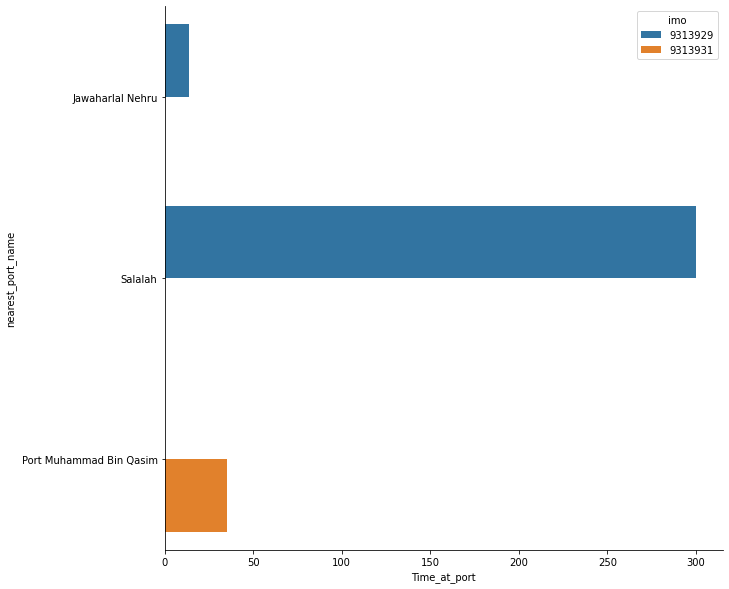

In [179]:
########## KPI - Anchored time at port for a specific voyage ##########
anchored_at_port = stalled_kpi_s2.query('naviation_status in ["At Anchor"] and schedule=="4"')

fig, ax1 = plt.subplots(figsize=(10, 10))
sns.barplot(x='Time_at_port', y='nearest_port_name', hue='imo', data=anchored_at_port, ax=ax1)
sns.despine(fig)

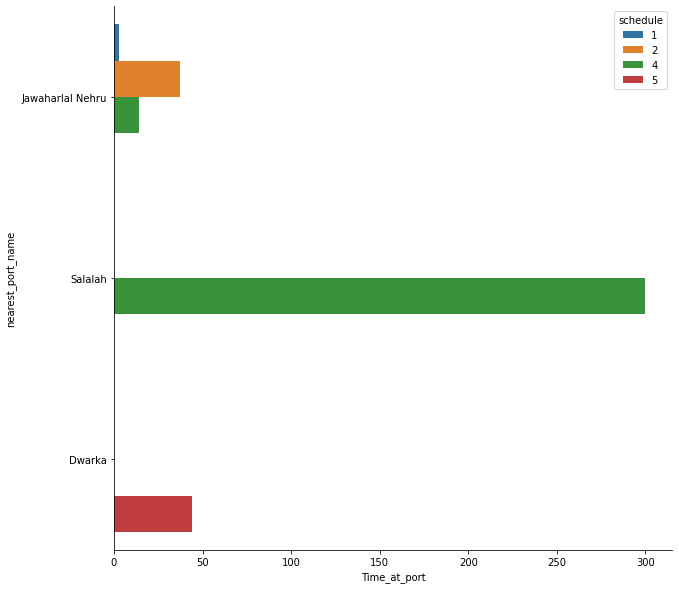

In [180]:
########## KPI - Anchored time at port for a specific IMO ##########
anchored_at_port = stalled_kpi_s2.query('naviation_status in ["At Anchor"] and imo==9313929')

fig, ax1 = plt.subplots(figsize=(10, 10))
sns.barplot(x='Time_at_port', y='nearest_port_name', hue='schedule', data=anchored_at_port, ax=ax1)
sns.despine(fig)

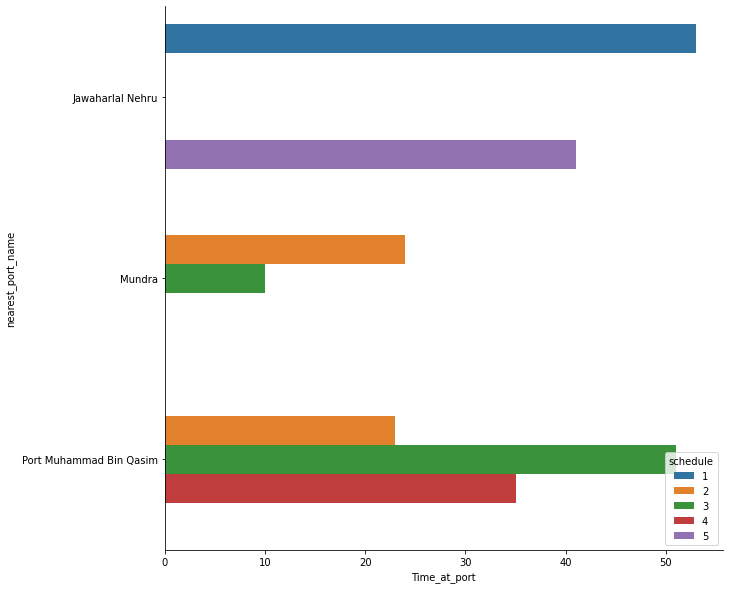

In [181]:
########## KPI - Anchored time at port for a specific IMO ##########
anchored_at_port = stalled_kpi_s2.query('naviation_status in ["At Anchor"] and imo==9313931')

fig, ax1 = plt.subplots(figsize=(10, 10))
sns.barplot(x='Time_at_port', y='nearest_port_name', hue='schedule', data=anchored_at_port, ax=ax1)
sns.despine(fig)

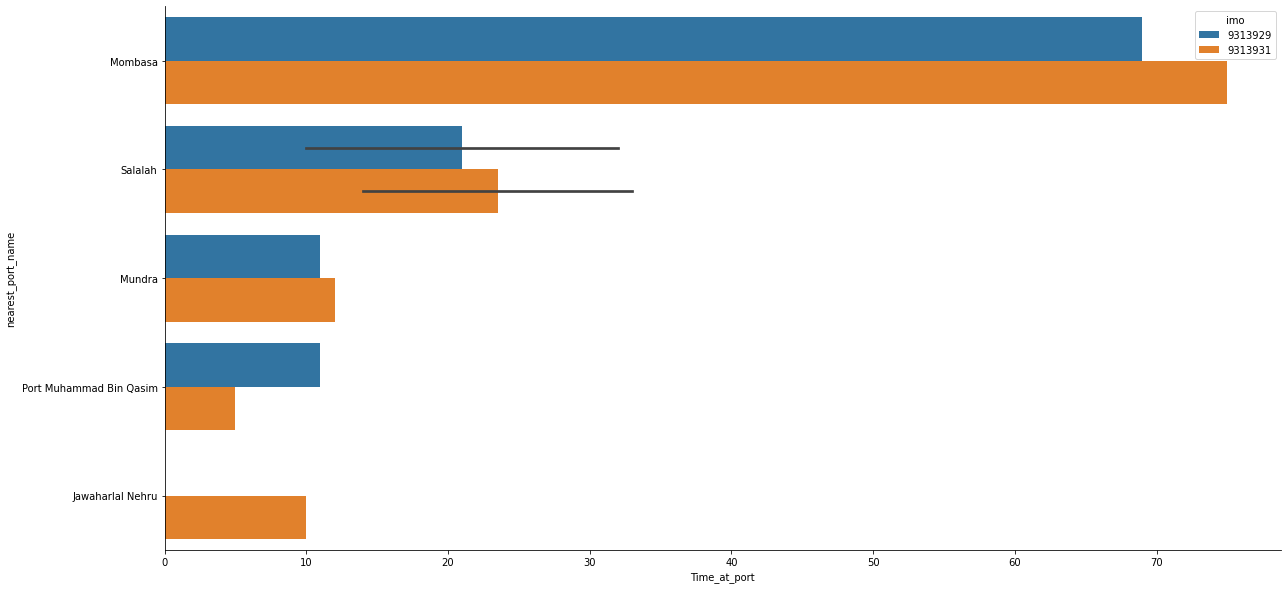

In [183]:
########## KPI - Moored time at port for a specific voyage ##########
moored_at_port = stalled_kpi_s2.query('naviation_status in ["Moored"] and schedule=="1"')

fig, ax1 = plt.subplots(figsize=(20, 10))
sns.barplot(x='Time_at_port', y='nearest_port_name', hue='imo', data=moored_at_port, ax=ax1)
sns.despine(fig)

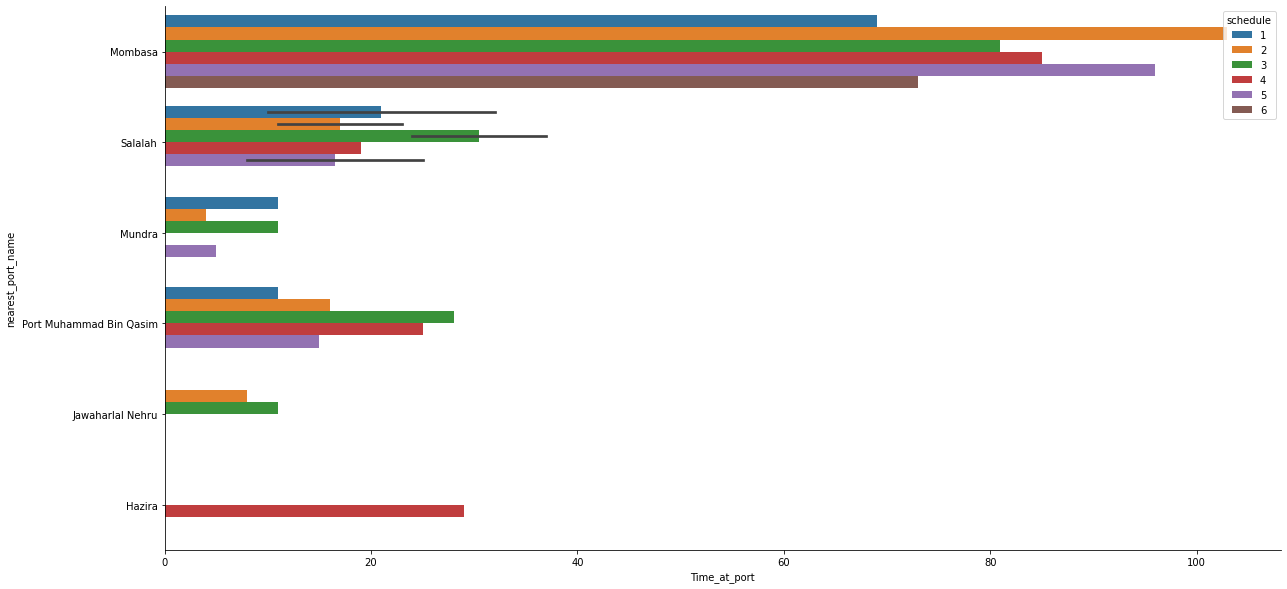

In [184]:
########## KPI - Moored time at port for a specific IMO ##########
moored_at_port = stalled_kpi_s2.query('naviation_status in ["Moored"] and imo==9313929')

fig, ax1 = plt.subplots(figsize=(20, 10))
sns.barplot(x='Time_at_port', y='nearest_port_name', hue='schedule', data=moored_at_port, ax=ax1)
sns.despine(fig)

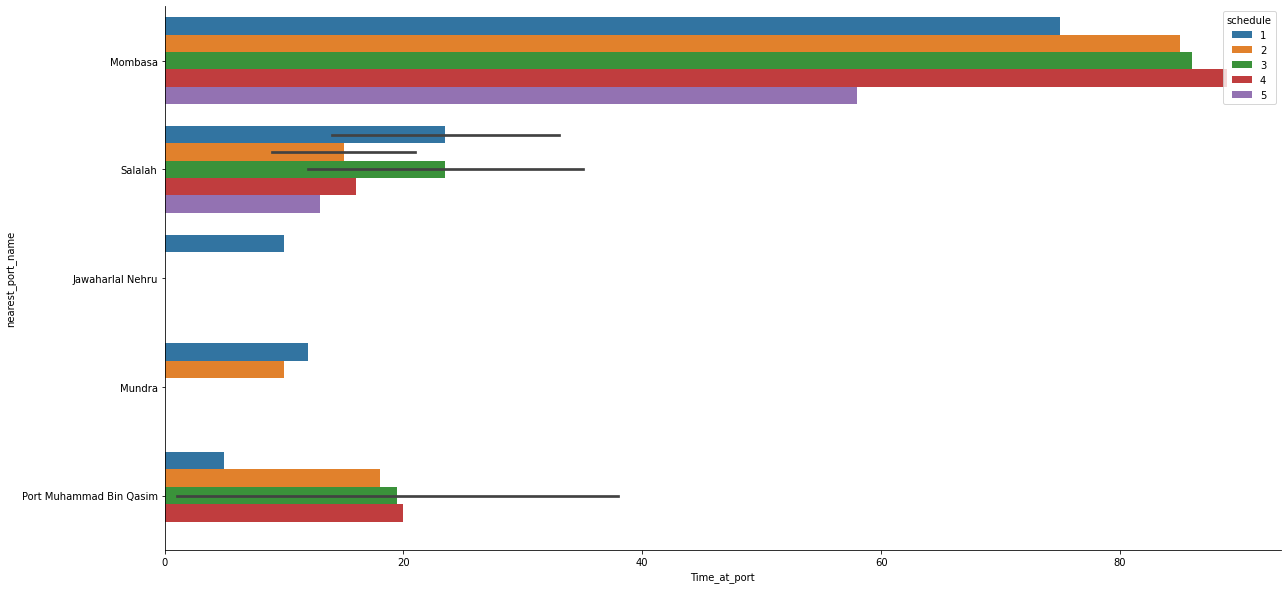

In [185]:
########## KPI - Moored time at port for a specific IMO ##########
moored_at_port = stalled_kpi_s2.query('naviation_status in ["Moored"] and imo==9313931')

fig, ax1 = plt.subplots(figsize=(20, 10))
sns.barplot(x='Time_at_port', y='nearest_port_name', hue='schedule', data=moored_at_port, ax=ax1)
sns.despine(fig)

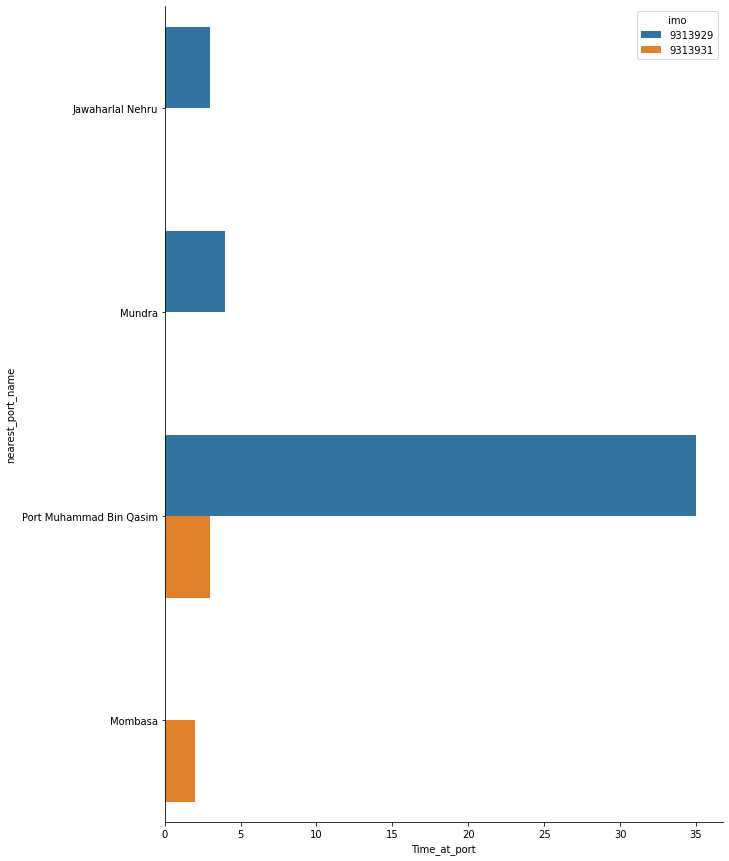

In [186]:
########## KPI - Underway time at port for a specific voyage ##########
underway_at_port = stalled_kpi_s2.query('naviation_status in ["Under Way"] and schedule=="1"')

fig, ax1 = plt.subplots(figsize=(10, 15))
sns.barplot(x='Time_at_port', y='nearest_port_name', hue='imo', data=underway_at_port, ax=ax1)
sns.despine(fig)

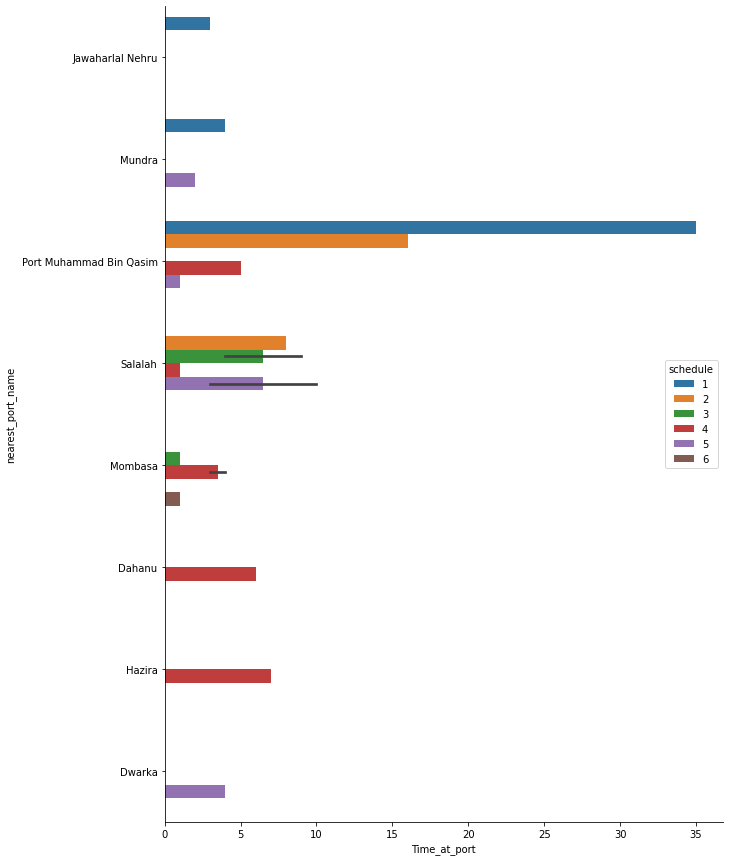

In [187]:
########## KPI - Underway time at port for a specific IMO ##########
underway_at_port = stalled_kpi_s2.query('naviation_status in ["Under Way"] and imo==9313929')

fig, ax1 = plt.subplots(figsize=(10, 15))
sns.barplot(x='Time_at_port', y='nearest_port_name', hue='schedule', data=underway_at_port, ax=ax1)
sns.despine(fig)

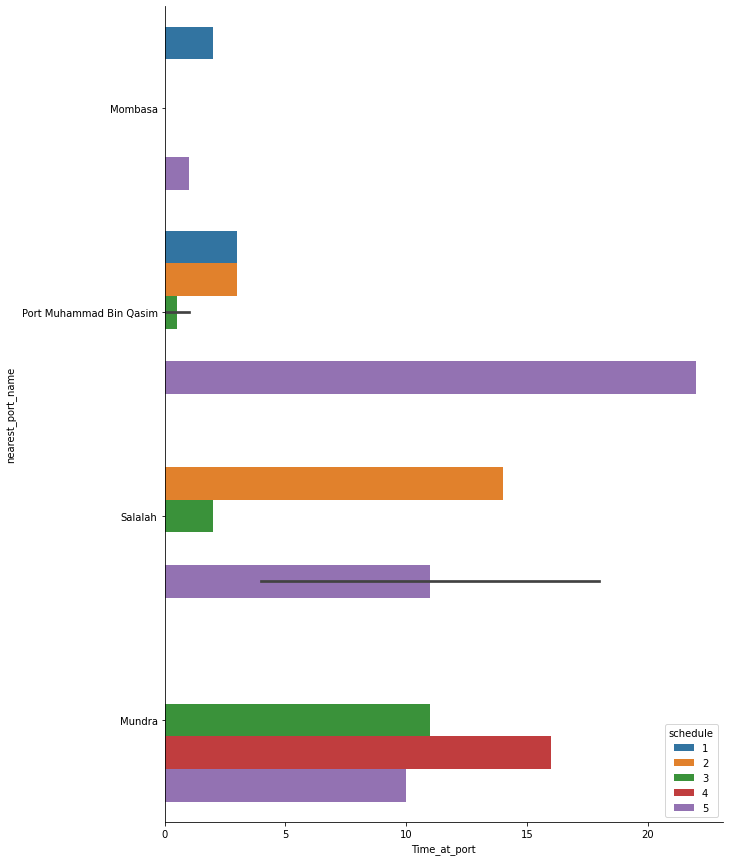

In [188]:
########## KPI - Underway time at port for a specific IMO ##########
underway_at_port = stalled_kpi_s2.query('naviation_status in ["Under Way"] and imo==9313931')

fig, ax1 = plt.subplots(figsize=(10, 15))
sns.barplot(x='Time_at_port', y='nearest_port_name', hue='schedule', data=underway_at_port, ax=ax1)
sns.despine(fig)

In [189]:
########## Sailing KPI Details Extraction ##########
sailing_kpi_s2 = pd.read_csv("Service_2.csv", header = 0)

sailing_kpi_s2 = sailing_kpi_s2.query('naviation_status in ["Under Way", "Under way sailing"] and speed > 3 and distance_from_nearest_port > 30 and schedule in ["1","2","3","4","5","6"]')
sailing_kpi_s2 = sailing_kpi_s2.sort_values(by=['imo','timestamp','schedule'])
sailing_kpi_s2['cum_speed_service'] = sailing_kpi_s2.groupby(['imo','schedule'])['speed'].cumsum()
sailing_kpi_s2.to_csv('sailing_kpi_s2_speed.csv')

In [190]:
# Average speed when sailing
avg=sailing_kpi_s2.groupby(['imo','schedule', 'destination'])['speed'].mean()
avg

imo      schedule  destination    
9313929  1         JNPT INDIA         11.759259
                   PORT QASIM         16.771429
                   SALALAH            14.500000
         2         INJHTTM>INLT4TM    12.740000
                   MOMBASA            12.950000
                   PORT QASIM         14.584211
                   SALALAH            13.861538
         3         MOMBASA            11.388889
                   MUNDRA             12.300000
                   PIPAVAV            15.148000
                   PORT QASIM         13.769231
                   SALALAH            13.114286
         4         JNPT               13.466667
                   MOMBASA            12.100000
                   PORT QASIM         17.979167
                   SALALAH            16.252778
         5         MOMBASA            13.675000
                   MUNDRA             12.754717
                   SALALAH            14.314583
         6         MOMBASA            12.550000
     

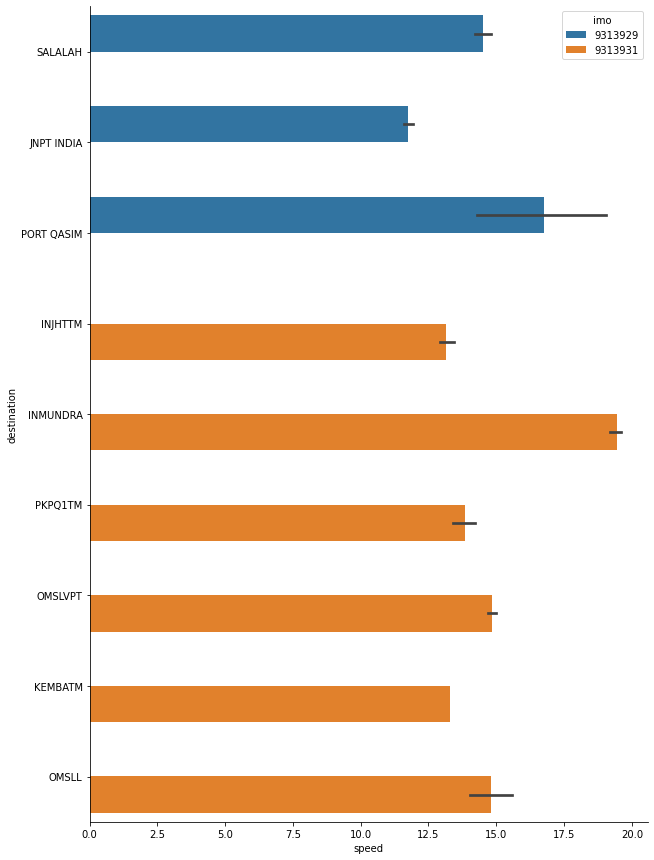

In [192]:
########## Mean speed for a specific voyage ##########
sailing = sailing_kpi_s2.query('schedule=="1"')

fig, ax1 = plt.subplots(figsize=(10, 15))
sns.barplot(x='speed', y='destination', hue='imo', data=sailing, ax=ax1)
sns.despine(fig)

In [198]:
# Identify delay at each port
delay_kpi_s2 = pd.read_csv("Service_2.csv", header = 0, parse_dates = ['timestamp','eta'],dayfirst=True)
delay_kpi_s2 = delay_kpi_s2.query('naviation_status in ["At Anchor", "Moored", "Under Way"] and speed < 3 and distance_from_nearest_port < 30 and schedule in ["1","2","3","4","5","6"]')

delay_kpi_s2['delay'] = delay_kpi_s2['timestamp'] - delay_kpi_s2['eta']
delay_kpi_s2['delay_at_port'] = np.where(((delay_kpi_s2['port'].shift(1).notnull()) & (delay_kpi_s2['nearest_port_name'] != delay_kpi_s2['port'].shift(1))), (delay_kpi_s2['delay'].dt.total_seconds()), np.nan_to_num(0))
delay_kpi_s2.to_csv('delay_kpi.csv')
delay_kpi_s2 = delay_kpi_s2.query('delay_at_port > 0')
delay_kpi_s2['delay_at_port (Hr)'] = delay_kpi_s2['delay_at_port'] // (3600)
delay_kpi_s2.to_csv('delay_kpi_s2.csv')

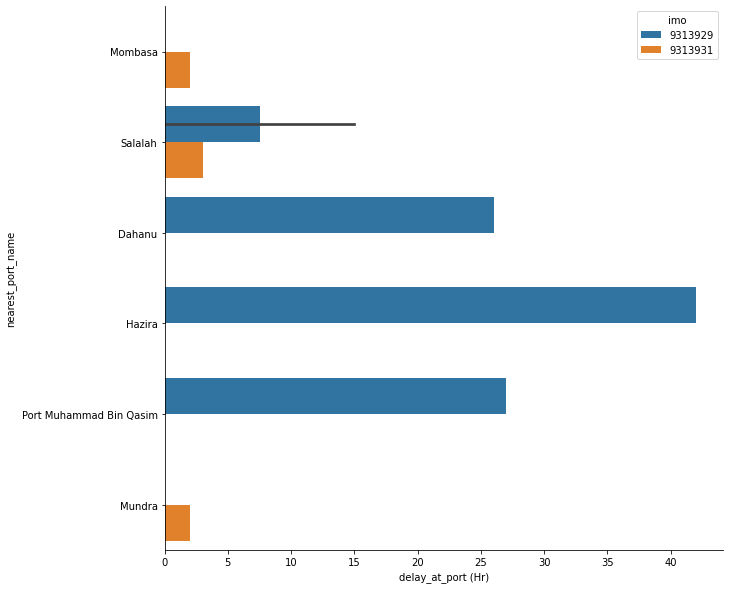

In [200]:
# Delay at each port for a specific voyage
delay_at_port = delay_kpi_s2.query('schedule == "4"')

fig, ax1 = plt.subplots(figsize=(10, 10))
sns.barplot(x='delay_at_port (Hr)', y='nearest_port_name', hue='imo', data=delay_at_port, ax=ax1)
sns.despine(fig)